Human-in-the-loop Selection

In [1]:
from src.utils import * 

# Question: Can you wrap this around a front-end, or a terminal console interface ? (I think terminal console is easier here)
get_action = lambda: input("Do you like this paper? (y/n/back): ").lower()
get_reject_feedback = lambda: input("Please provide feedback for rejection: ")

get_action: Callable = lambda: input("Do you like this paper? (y/n/back): ").lower(), 
get_reject_feedback: Callable = lambda: input("Please provide feedback for rejection: ")
print_paper: Callable = lambda paper: print(f"Title: {paper['title']}\nScore: {paper['score']}\nAI Comment: {paper['comment']}")
print_action_error: Callable = lambda: print("Invalid action. Please choose y, n, or back.")
print_summary_begin: Callable = lambda: print("--- Failed to recommend papers, reflecting on human preference ---")
print_summary: Callable = lambda summary: print(f"Summary of human preference: \n{summary}")

def build_research_graph(
    get_action: Callable = lambda: input("Do you like this paper? (y/n/back): ").lower(), 
    get_reject_feedback: Callable = lambda: input("Please provide feedback for rejection: "),
    print_paper: Callable = lambda paper: print(f"Title: {paper['title']}\nScore: {paper['score']}\nAI Comment: {paper['comment']}"),
    print_action_error: Callable = lambda: print("Invalid action. Please choose y, n, or back."),
    print_summary_begin: Callable = lambda: print("--- Failed to recommend papers, reflecting on human preference ---"),
    print_summary: Callable = lambda summary: print(f"Summary of human preference: \n{summary}")):
    """ 
    1. Scrape ArXiv for newest 200 AI papers 
    2. AI do ranking & analysis base on abstracts
    3. Human select 5 papers from top-ranked papers
    4. Conditional on human acceptance, proceed, otherwise, summarize human preference and go back to 2.
    -- Output 5 papers & analysis
    """
    model = ChatOpenAI(model="gpt-4o")
    builder = StateGraph(State)
    
    # Research graph part
    research_entry_point = "crawl_arxiv_node"
    builder.add_node(research_entry_point, CrawlNode(research_entry_point))
    builder.add_edge(START, research_entry_point)
    
    builder = add_selection_nodes(builder, research_entry_point, "human_approval_node", model)
    
    # Human approval graph part
    human_approval_node = "human_approval_node"
    builder.add_node(human_approval_node, HumanApprovalNode(human_approval_node,
                                                            get_action=get_action,
                                                            get_reject_feedback=get_reject_feedback,
                                                            print_paper=print_paper,
                                                            print_action_error=print_action_error,
                                                            print_summary_begin=print_summary_begin,
                                                            print_summary=print_summary
                                                            ))  # Assuming HumanApprovalNode is defined elsewhere
    
    # So here we ought to have a conditional edge, if there is "redo" in the message, we re-run from research_entry_point
    builder.add_conditional_edges(human_approval_node, 
                                  should_continue,
                                  {
                                    "continue": END,
                                    "redo": research_entry_point,
                                  },)
        
    return builder.compile()


In [2]:
app = build_research_graph()

# Run the graph with intermediate inference
result = app.invoke({
    "messages": [],
    "papers": []
})

Presenting Top Papers selected by AI
Title: SAM2-Adapter: Evaluating & Adapting Segment Anything 2 in Downstream Tasks: Camouflage, Shadow, Medical Image Segmentation, and More
Score: 90
AI Comment: The paper addresses the limitations of the SAM2 model in handling specific segmentation tasks by introducing SAM2-Adapter. This is a significant contribution as it enhances the performance of a widely-used model in challenging applications. The practical implications and improvements in diverse tasks make this work highly relevant.
Title: Towards Multimodal Emotional Support Conversation Systems
Score: 88
AI Comment: The introduction of the MESC dataset and the SMES framework marks a significant advancement in conversational AI for mental health support. The multimodal approach addresses the limitations of single-modal systems, enhancing empathy and responsiveness. The rigorous evaluations underscore the framework's potential. However, the practical deployment and integration into existing 

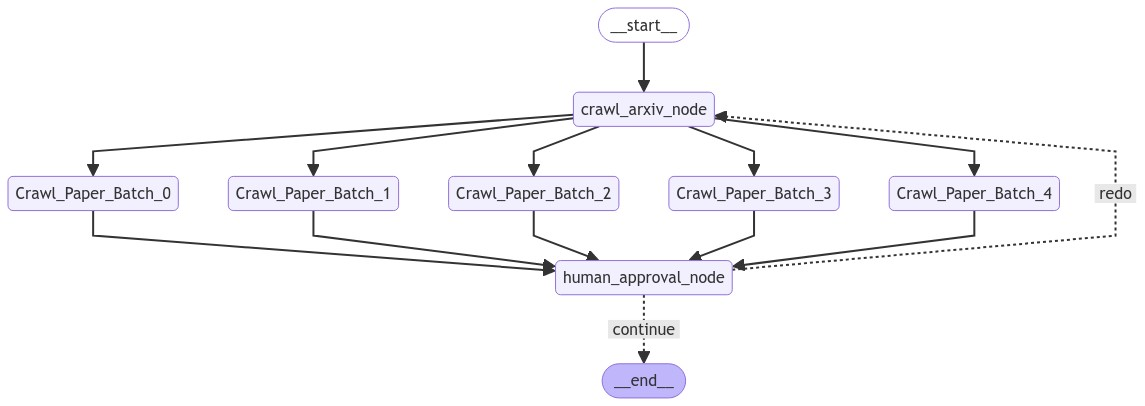

In [4]:
from IPython.display import Image, display
from langchain_core.runnables.graph import CurveStyle, MermaidDrawMethod, NodeStyles

display(
    Image(
        app.get_graph().draw_mermaid_png(
            draw_method=MermaidDrawMethod.API,
        )
    )
)

In [ ]:
# Do a streamlit 

In [9]:
result["papers"]

# Select the top papers
# Select the top papers based on score
top_papers = sorted(result["papers"], key=lambda x: x.get('score', 0), reverse=True)[:5]

print("Top 5 papers:")
for i, paper in enumerate(top_papers, 1):
    print(f"{i}. {paper['title']} (Score: {paper.get('score', 'N/A')})")
    print(f"   Comment: {paper.get('comment', 'No comment')[:100]}...")  # Truncate long comments
    print()

Top 5 papers:
1. SAM2-Adapter: Evaluating & Adapting Segment Anything 2 in Downstream Tasks: Camouflage, Shadow, Medical Image Segmentation, and More (Score: 90)
   Comment: The paper makes a significant contribution by improving the performance of SAM2 on complex segmentat...

2. Evaluating the Impact of Pulse Oximetry Bias in Machine Learning under Counterfactual Thinking (Score: 90)
   Comment: The study addresses an important issue of algorithmic bias in healthcare, specifically the bias in p...

3. Addressing Model and Data Heterogeneity in Multimodal Large Language Model Training (Score: 90)
   Comment: The MMScale framework addresses critical issues of model and data heterogeneity in multimodal large ...

4. GMAI-MMBench: A Comprehensive Multimodal Evaluation Benchmark Towards General Medical AI (Score: 90)
   Comment: GMAI-MMBench presents an extensive and structured benchmark for evaluating large vision-language mod...

5. MedTrinity-25M: A Large-scale Multimodal Dataset with 